In [1]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
pwd

'/atlas/u/kechoi/multi-fairgen/notebooks'

In [10]:
cd ..

/atlas/u/kechoi/multi-fairgen


In [11]:
from classification.models.mlp import MLPClassifier, MLPClassifierv2
from classification.models.flow_mlp import FlowClassifier
import argparse
import yaml

# Helper functions

In [12]:
def logsumexp_1p(s):
    # numerically stable implementation of log sigmoid via logsumexp
    # NOTE: this assumes that you feed in -s for the positive probabilities
    if len(s.size()) == 2:
        s = s.squeeze()
    x = torch.stack([s, torch.zeros_like(s)], -1)
    val, _ = torch.max(x, 1)
    val = val.repeat(2,1).T
    logsigmoid = torch.clamp(s, 0) + torch.log(
        torch.sum(torch.exp(x - val), 1))

    return -logsigmoid

# Dataset

In [13]:
import torch
from torch.distributions import Normal

In [14]:
p = Normal(0, 1)
q = Normal(3, 1)

In [15]:
px = p.sample((2000,2))
qx = q.sample((2000,2))

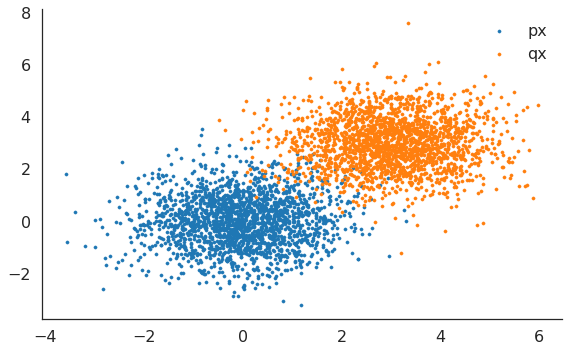

In [16]:
plt.figure(figsize=(8,5))
plt.scatter(px[:,0], px[:,1], label='px', s=10)
plt.scatter(qx[:,0], qx[:,1], label='qx', s=10)

plt.tight_layout()
plt.legend()
sns.despine()

In [17]:
from scipy import stats
# can u just get hte numpy thing
p_rv = stats.norm(0, 1)  # stdev
q_rv = stats.norm(3, 1)  # stdev

In [18]:
true_xs = torch.cat([qx, px])
true_xs.shape

torch.Size([4000, 2])

In [19]:
np_density = 0.5 * (stats.multivariate_normal([0,0], 1).pdf(true_xs.data.cpu().numpy()) + stats.multivariate_normal([3,3], 1).pdf(true_xs.data.cpu().numpy()))
np_density

array([0.0224889 , 0.0629705 , 0.01667257, ..., 0.02512898, 0.03939191,
       0.05105587])

In [20]:
true_ratios = torch.exp((q.log_prob(true_xs).sum(-1) - p.log_prob(true_xs).sum(-1)))

In [21]:
true_log_r = torch.log(true_ratios)

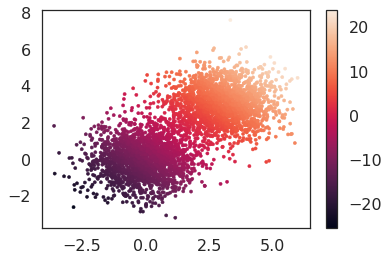

In [22]:
plt.scatter(true_xs[:,0].data.cpu().numpy(), true_xs[:,1].data.cpu().numpy(), s=10, c=true_log_r.data.cpu().numpy())
plt.colorbar()

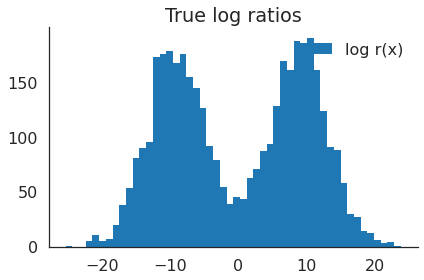

In [23]:
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
plt.title('True log ratios')

plt.legend()
sns.despine()
plt.tight_layout()

------

# DRE Clf in X-Space

In [22]:
cd src

/atlas/u/kechoi/multi-fairgen/src


In [23]:
device = 'cuda'

In [54]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    if isinstance(config, list):
        # from creating config files
        for i in range(len(config)):
            for key, value in config[i].items():
                if isinstance(value, dict):
                    new_value = dict2namespace(value)
                else:
                    new_value = value
                setattr(namespace, key, new_value)
    else:
        # vanilla training
        for key, value in config.items():
            if isinstance(value, dict):
                new_value = dict2namespace(value)
            else:
                new_value = value
            setattr(namespace, key, new_value)
    return namespace

In [55]:
with open(os.path.join('configs/classification/gmm/mlp_perc1.0.yaml'), 'r') as f:
    config = yaml.safe_load(f)
new_config = dict2namespace(config)

In [56]:
from torch import autograd

----

In [58]:
# load model
x_mlp = MLPClassifierv2(new_config)
restore_file = 'classification/results/gmm_perc1.0_v2/checkpoints/model_best.pth'
state = torch.load(restore_file, map_location='cuda')
x_mlp.load_state_dict(state['state_dict'])
x_mlp = x_mlp.to(device)
x_mlp.eval()

true_xs = torch.from_numpy(true_xs).float().cuda()
true_xs.requires_grad_(True)

# get data
logits, probas = x_mlp(true_xs.cuda())
y = torch.cat([
    torch.ones(len(true_xs)//2),
    torch.zeros(len(true_xs)//2)
]).to(device)

# grads
gradients = autograd.grad(probas.sum(), true_xs, create_graph=True, only_inputs=True)[0]
grad1 = autograd.grad(logits.sum(), true_xs, create_graph=True, only_inputs=True)[0]


grad_norms = gradients.norm(2, dim=1)
logit_grad_norms = grad1.norm(2, dim=1)

In [59]:
true_xs = true_xs.data.cpu().numpy()
grad_norms = np.ravel(grad_norms.data.cpu().numpy())
logit_grad_norms = np.ravel(logit_grad_norms.data.cpu().numpy())

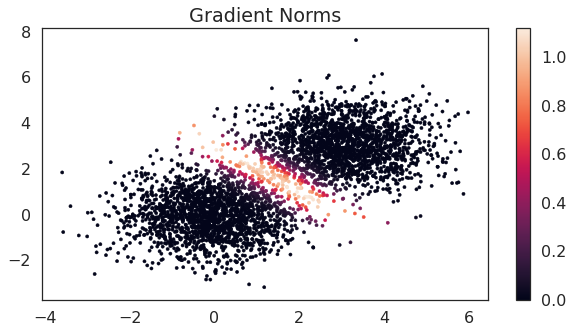

In [60]:
# this is for sigmoid
plt.figure(figsize=(10,5))
plt.scatter(true_xs[:,0], true_xs[:,1], s=10, c=grad_norms)
# plt.clim(min_, max_)
# plt.colorbar()
plt.title('Gradient Norms')
plt.colorbar()

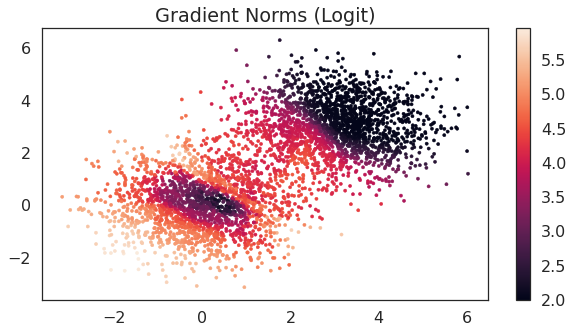

In [31]:
# this is for logits
plt.figure(figsize=(10,5))
plt.scatter(true_xs[:,0], true_xs[:,1], s=10, c=logit_grad_norms)
# plt.clim(min_, max_)
# plt.colorbar()
plt.title('Gradient Norms (Logit)')
plt.colorbar()

---

# Separate Flow Model

In [26]:
cd src

/atlas/u/kechoi/multi-fairgen/src


In [40]:
device = 'cuda'

In [41]:
# load flow
import os
from flows.models.maf import MAF

model = MAF(5, 
            2, 
            100, 
            1, 
            None, 
            'relu', 
            'sequential', 
            batch_norm=True)
restore_file = 'flows/results/gmm_perc1.0/'
state = torch.load(os.path.join(restore_file, "best_model_checkpoint.pt"), map_location='cuda')
model.load_state_dict(state['model_state'])
model = model.to(device)
model.eval()

MAF(
  (net): FlowSequential(
    (0): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (1): BatchNorm()
    (2): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (3): BatchNorm()
    (4): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      

In [42]:
# flow mlp config
with open(os.path.join('configs/classification/gmm/mlp_z_perc1.0.yaml'), 'r') as f:
    config = yaml.safe_load(f)
new_config = dict2namespace(config)

In [45]:
# load model
z_mlp = MLPClassifierv2(new_config)
restore_file = 'classification/results/gmm_z_perc1.0_v2/checkpoints/model_best.pth'
state = torch.load(restore_file, map_location='cuda')
z_mlp.load_state_dict(state['state_dict'])
z_mlp = z_mlp.to(device)
z_mlp.eval()

# load flow
model.eval()

# encode data
true_xs = torch.from_numpy(true_xs).float().cuda()
true_xs.requires_grad_(True)
z, _ = model.forward(true_xs.cuda())
logits, probas = z_mlp(z.cuda())

# get data
y = torch.cat([
    torch.ones(len(true_xs)//2),
    torch.zeros(len(true_xs)//2)
]).to(device)

# grads
gradients = autograd.grad(probas.sum(), true_xs, create_graph=True, only_inputs=True)[0]
grad1 = autograd.grad(logits.sum(), true_xs, create_graph=True, only_inputs=True)[0]

z_grad_norms = gradients.norm(2, dim=1)
z_logit_grad_norms = grad1.norm(2, dim=1)

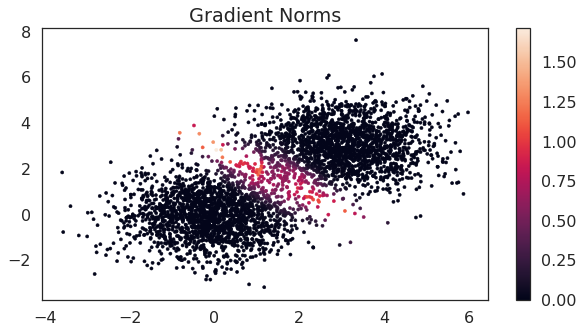

In [46]:
z_grad_norms = z_grad_norms.data.cpu().numpy()
true_xs = true_xs.data.cpu().numpy()

# this is for sigmoid
plt.figure(figsize=(10,5))
plt.scatter(true_xs[:,0], true_xs[:,1], s=10, c=z_grad_norms)
# plt.clim(min_, max_)
# plt.colorbar()
plt.title('Gradient Norms')
plt.colorbar()

----

In [62]:
min_ = min(grad_norms.min(), z_grad_norms.min())
max_ = max(grad_norms.max(), z_grad_norms.max())

In [36]:
true_xs = true_xs.data.cpu().numpy()
z_grad_norms = z_grad_norms.data.cpu().numpy()

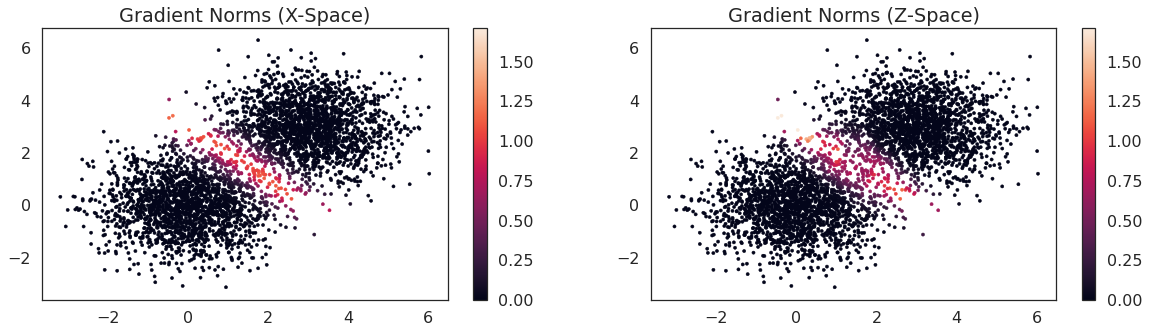

In [37]:
# new
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.scatter(true_xs[:,0], true_xs[:,1], s=10, c=grad_norms)
plt.clim(min_, max_)
plt.title('Gradient Norms (X-Space)')
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(true_xs[:,0], true_xs[:,1], s=10, c=z_grad_norms)
plt.clim(min_, max_)
plt.title('Gradient Norms (Z-Space)')
plt.colorbar()

# Or Joint Flow Model?

In [47]:
with open(os.path.join('configs/classification/gmm/joint_flow_mlp_perc1.0.yaml'), 'r') as f:
    config = yaml.safe_load(f)
new_config = dict2namespace(config)

In [49]:
joint_flow_mlp = FlowClassifier(new_config)
restore_file = 'classification/results/joint_gmm_flow_mlp_perc1.0_alpha0.01/checkpoints/model_best.pth'
state = torch.load(restore_file, map_location='cuda')
joint_flow_mlp.load_state_dict(state['state_dict'])
joint_flow_mlp = joint_flow_mlp.to(device)
joint_flow_mlp.eval()

# xs require grad
true_xs = torch.from_numpy(true_xs)
true_xs.requires_grad_(True)
logits, probas = joint_flow_mlp(true_xs.cuda())

# grads
gradients = autograd.grad(probas.sum(), true_xs, create_graph=True, only_inputs=True)[0]
grad1 = autograd.grad(logits.sum(), true_xs, create_graph=True, only_inputs=True)[0]

joint_z_grad_norms = gradients.norm(2, dim=1)
joint_z_logit_grad_norms = grad1.norm(2, dim=1)

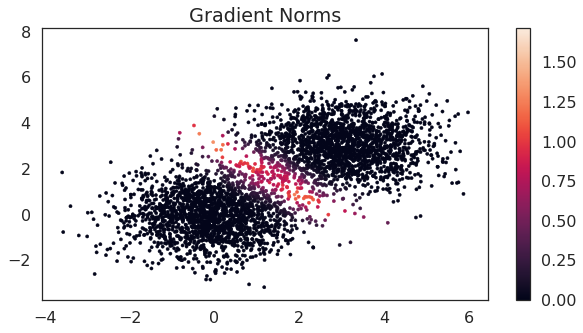

In [63]:
# joint_z_grad_norms = joint_z_grad_norms.data.cpu().numpy()
# true_xs = true_xs.data.cpu().numpy()

# this is for sigmoid
plt.figure(figsize=(10,5))
plt.scatter(true_xs[:,0], true_xs[:,1], s=10, c=joint_z_grad_norms)
plt.clim(min_, max_)
# plt.colorbar()
plt.title('Gradient Norms')
plt.colorbar()

### Logits

In [113]:
lmin_ = min(logit_grad_norms.min(), z_logit_grad_norms.min())
lmax_ = max(logit_grad_norms.max(), z_logit_grad_norms.max())

In [114]:
z_logit_grad_norms = z_logit_grad_norms.data.cpu().numpy()

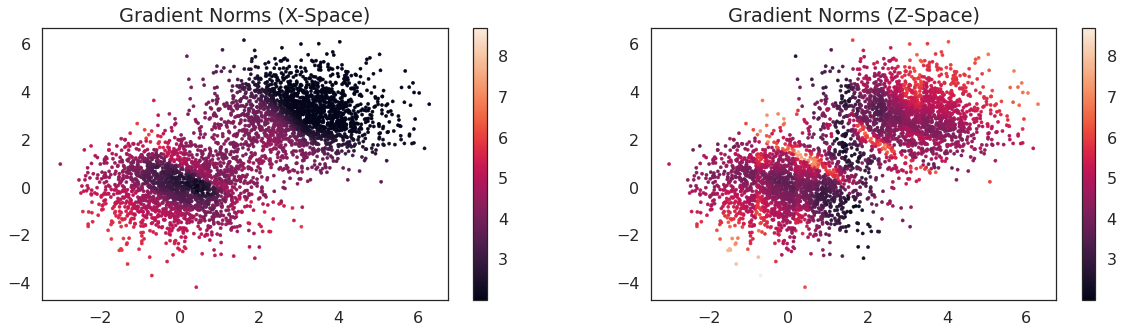

In [115]:
# new
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.scatter(true_xs[:,0], true_xs[:,1], s=10, c=logit_grad_norms)
plt.clim(lmin_, lmax_)
plt.title('Gradient Norms (X-Space)')
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(true_xs[:,0], true_xs[:,1], s=10, c=z_logit_grad_norms)
plt.clim(lmin_, lmax_)
plt.title('Gradient Norms (Z-Space)')
plt.colorbar()

-----------------

what about the true density?

In [38]:
grad_norms

array([2.1770434e-06, 3.9458400e-04, 2.5840092e-01, ..., 1.2314819e-04,
       7.1788694e-05, 7.3229065e-05], dtype=float32)

In [39]:
z_grad_norms

array([0.0000000e+00, 7.6506456e-04, 3.0407619e-01, ..., 2.2882483e-05,
       3.0925657e-04, 3.2372991e-05], dtype=float32)

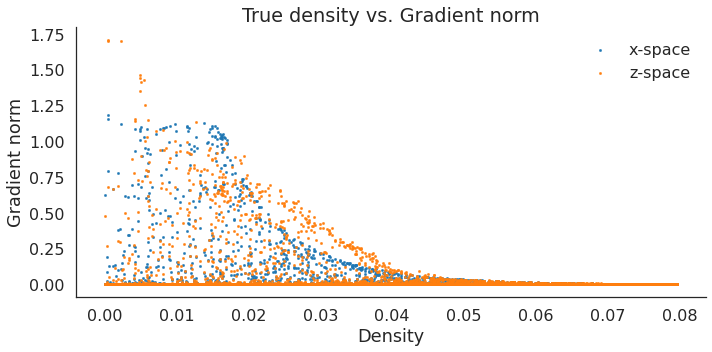

In [40]:
plt.figure(figsize=(10,5))
plt.scatter(np_density, grad_norms, s=5, label='x-space')
plt.scatter(np_density, z_grad_norms, s=5, label='z-space')
# plt.xscale('log')

plt.title('True density vs. Gradient norm')
plt.xlabel('Density')
plt.ylabel('Gradient norm')
plt.legend()

sns.despine()
plt.tight_layout()